In [14]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow_io as tfio
from pathlib import Path

from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

**Build Data Loading Function**

In [15]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

**Create Tensorflow Dataset**

In [16]:
train_dir = Path('train_data/train/')
test_dir = Path('train_data/test/')

In [17]:
def transform(value):
    if value == "capuchinbird":
        return tf.one_hot(0,5)
    if value == "cricket":
        return tf.one_hot(1,5)
    if value == "robin":
        return tf.one_hot(2,5)
    if value == "sparrow":
        return tf.one_hot(3,5)   
    if value == "owl":
        return tf.one_hot(4,5)  

In [18]:
train_filepaths = pd.Series(list(train_dir.glob(r'**/*.wav'))).astype(str)
train_animals = pd.Series(train_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1])).astype(str)

train_lables = train_animals.map(transform).to_list()

train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(train_filepaths), tf.data.Dataset.from_tensor_slices(train_lables)))

In [19]:
test_filepaths = pd.Series(list(train_dir.glob(r'**/*.wav'))).astype(str)
test_animals = pd.Series(test_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1])).astype(str)

test_lables = test_animals.map(transform).to_list()

test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(test_filepaths), tf.data.Dataset.from_tensor_slices(test_lables)))

**Build Preprocessing Function to Convert to Spectrogram**

In [20]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

**Create Training and Testing Partitions**

In [21]:
train = train.map(preprocess)
train = train.cache()
train = train.shuffle(buffer_size=1000)
train = train.batch(16)
train = train.prefetch(8)

test = test.map(preprocess)
test = test.cache()
test = test.shuffle(buffer_size=1000)
test = test.batch(16)
test = test.prefetch(8)

**Build Model**

In [22]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [23]:
model.compile('Adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten_1 (Flatten)         (None, 6019376)           0         
                                                                 
 dense_2 (Dense)             (None, 128)               770480256 
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 770,483,381
Trainable params: 770,483,381
Non-trainable params: 0
_________________________________________________________________


**Train**

In [25]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
22/22 [==============================] - 116s 5s/step - loss: 6.4664 - recall_1: 0.8338 - precision_1: 0.8754 - val_loss: 0.1394 - val_recall_1: 0.9852 - val_precision_1: 0.9881
Epoch 2/4
22/22 [==============================] - 107s 5s/step - loss: 0.1056 - recall_1: 0.9733 - precision_1: 0.9762 - val_loss: 0.0300 - val_recall_1: 0.9881 - val_precision_1: 0.9881
Epoch 3/4
22/22 [==============================] - 107s 5s/step - loss: 0.0484 - recall_1: 0.9911 - precision_1: 0.9911 - val_loss: 0.0018 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/4
22/22 [==============================] - 112s 5s/step - loss: 0.0247 - recall_1: 0.9881 - precision_1: 0.9881 - val_loss: 0.0129 - val_recall_1: 0.9941 - val_precision_1: 0.9941


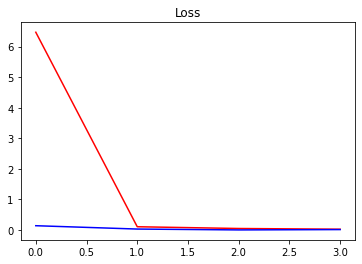

In [26]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

**Test Model with a Single Clip**

In [48]:
X_test, y_test = test.as_numpy_iterator().next()
y_test

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [49]:
yhat = model.predict(X_test)
output = list()
for y in yhat:
    if y[0] > 0.5:
        y[0] = 1
    else:
        y[0] = 0
    if y[1] > 0.5:
        y[1] = 1
    else:
        y[1] = 0
    if y[2] > 0.5:
        y[2] = 1
    else:
        y[2] = 0
    if y[3] > 0.5:
        y[3] = 1
    else:
        y[3] = 0
    if y[4] > 0.5:
        y[4] = 1
    else:
        y[4] = 0
    output.append(list(y))
output

[[0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0]]